<a href="https://colab.research.google.com/github/dailyLi/yelp_da/blob/main/Yelp_word_cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
import pandas as pd
import numpy as np
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.svm import LinearSVC

from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Read data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('drive/My Drive/Colab Notebooks/Yelp_sentiment/svc_predictions.csv')

In [7]:
data

,Unnamed: 0,user_id,business_id,Stars,Review,Polarity
0,0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is...",Negative
1,1,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,I've taken a lot of spin classes over the year...,Positive
2,2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...,Positive
3,3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo...",Positive
4,4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,Cute interior and owner (?) gave us tour of up...,Positive
...,...,...,...,...,...,...
49995,49995,_-x9v81zddshIEwRirV7kQ,GBTPC53ZrG1ZBY3DT8Mbcw,4,Came here first for breakfast and had their yu...,Positive
49996,49996,VEOTasfs8zYs7grZ4C5Xfw,EQ-TZ2eeD_E0BHuvoaeG5Q,2,Food was good. I had a decent breakfast but no...,Negative
49997,49997,AT_p7NkLqd50ugp3wjFg2Q,_RFqyBgklIBqOAM-zzV_WQ,3,It's cool that Second Image is trying. They so...,Positive
49998,49998,NSCNU_j0vSdeRMIme3H0rg,8agPzX-O-8LEDjDNloSdzQ,4,"Best shrimp on the beach! Steamed to order, d...",Positive


In [26]:
data.groupby(['business_id']).count().sort_values('Review', ascending=False)

,Unnamed: 0,user_id,Stars,Review,Polarity
business_id,,,,,
GBTPC53ZrG1ZBY3DT8Mbcw,503,503,503,503,503
PY9GRfzr4nTZeINf346QOw,244,244,244,244,244
W4ZEKkva9HpAdZG88juwyQ,223,223,223,223,223
vN6v8m4DO45Z4pp8yxxF_w,202,202,202,202,202
pSmOH4a3HNNpYM82J5ycLA,197,197,197,197,197
...,...,...,...,...,...
DSXuvdbpW1_A79_Fy4PZOw,1,1,1,1,1
5ue5s7yFGjQ_CjeVGGhPFg,1,1,1,1,1
TWro4PurWUenW5BErh4cjQ,1,1,1,1,1


## Preprocessing
Takes in a df to performs the cleaning:
- Lower capital letters
- Remove all punctuation
- Reduce words to their word stem
- Return a list of words

In [8]:
stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()

In [9]:
def text_process(data):
   
    for i in range(len(data)):
        line = data[i]
        line = line.lower()
        translation = str.maketrans("","", string.punctuation);
        line = line.translate(translation)
        split = word_tokenize(line)
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        filtered = []
        for token in split:
            if re.search('[a-zA-Z]', token):    
                filtered.append(token)
        
        # filter out stop words
        word = [i for i in filtered if i not in stopwords.words('english')]
        word = [i for i in filtered if i not in STOPWORDS]
        
        d = [stemmer.stem(word) for word in word] 
        d = [wordnet_lemmatizer.lemmatize(word) for word in d]
        data[i] = d
    return data

## Word cloud

In [10]:
def top_words(text_df):
    train = list(text_df)
    text = text_process(train)
    text = sum(text,[])
    
    counts = Counter(text)
    wordcloud = WordCloud(    
                          background_color='white',
                          max_words=100,
                          max_font_size=50,
                          min_font_size=10,
                          random_state=40,
                        
                         ).fit_words(counts)
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [16]:
negative = data['Review'][data['Polarity'] == "Negative"].head(10000)

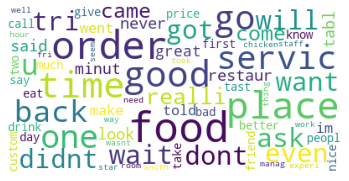

In [17]:
top_words(negative)

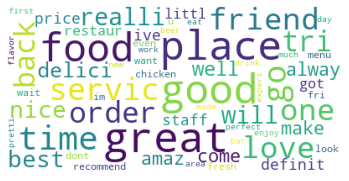

In [18]:
positive = data['Review'][data['Polarity'] == "Positive"].head(10000)
top_words(positive)

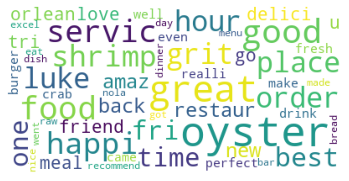

In [42]:
positive_1 = data[(data['business_id'] == 'GBTPC53ZrG1ZBY3DT8Mbcw') & (data['Polarity'] == 'Positive')]
top_words(positive_1['Review'])

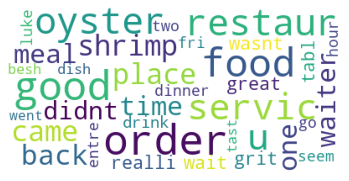

In [43]:
negative_1 = data[(data['business_id'] == 'GBTPC53ZrG1ZBY3DT8Mbcw') & (data['Polarity'] == 'Negative')]
top_words(negative_1['Review'])

## Importance features extraction

Discover the key word (or words/phrases) that contribute to the polarity of the reviews. 

In [34]:
def onegram(business_id):
    
    train  = data[data['business_id'] == business_id]
    train_data =  list(train['Review'])
    train_label = list(train['Polarity'])
    
    text = text_process(train_data)
    text = sum(text,[])
    text = set(text)
    text = list(text)
    transformer = TfidfVectorizer() 
    cvectorizer = transformer.fit(text)
    transformed = cvectorizer.transform(train['Review'])  
    #print(cvectorizer.get_feature_names())

    # SVM regression
    clf = LinearSVC()
    clf.fit(transformed,train_label)
    
    coefficients = clf.coef_.ravel()
    pos_coefficients = np.argsort(coefficients )[-10:]
    neg_coefficients = np.argsort(coefficients )[:10]
    combine = np.hstack([neg_coefficients, pos_coefficients])
    
    plt.figure(figsize=(10, 5))
    colors = ['red' if i < 0 else 'green' for i in coefficients[combine]]
    plt.bar(np.arange(2 * 10), coefficients[combine], color=colors)
    feature_names = np.array(cvectorizer.get_feature_names())
    
    plt.title('why the restaurant is rated positively or negatively', fontsize = 15)
    plt.xticks(np.arange( 0, 2 * 10), feature_names[combine], rotation=40, ha='right')
    plt.show()

In [30]:
def bigram(business_id):

    train  = data[data['business_id'] == business_id]
    train_data =  list(train['Review'])
    train_label = list(train['Polarity'])
    
    # TfidfVectorizer Transform
    transformer = TfidfVectorizer(stop_words ='english', ngram_range=(2,2))
    cvectorizer = transformer.fit(train['Review'])
    transformed = cvectorizer.transform(train['Review'])

    # SVM regression
    clf = LinearSVC()
    clf.fit(transformed,train_label)
    
    coefficients = clf.coef_.ravel()
    pos_coefficients = np.argsort(coefficients )[-10:]
    neg_coefficients = np.argsort(coefficients )[:10]
    combine = np.hstack([neg_coefficients, pos_coefficients])
    
    plt.figure(figsize=(10, 5))
    colors = ['red' if i < 0 else 'green' for i in coefficients[combine]]
    plt.bar(np.arange(2 * 10), coefficients[combine], color=colors)
    feature_names = np.array(cvectorizer.get_feature_names())
    
    plt.title('why the restaurant is rated positively or negatively', fontsize = 15)
    plt.xticks(np.arange( 0, 2 * 10), feature_names[combine], rotation=40, ha='right')
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


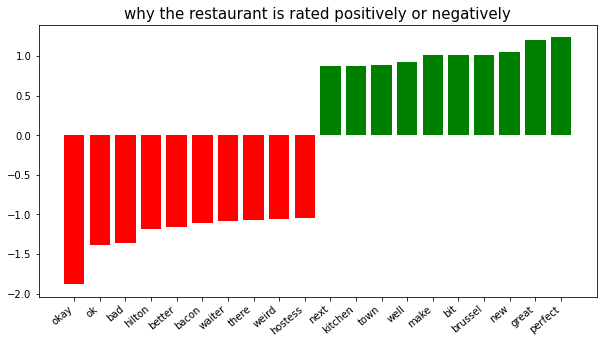

In [35]:
onegram('GBTPC53ZrG1ZBY3DT8Mbcw')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


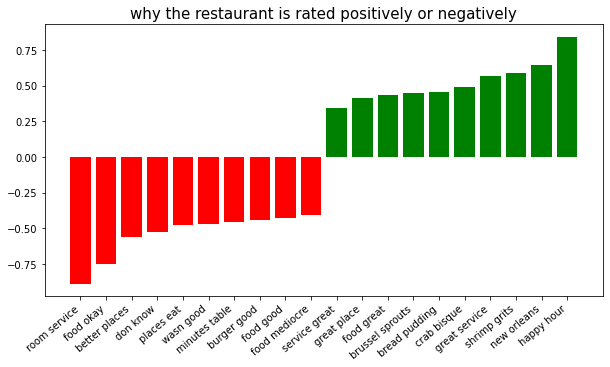

In [32]:
bigram('GBTPC53ZrG1ZBY3DT8Mbcw')